# 2D projections for DNN-based reconstruction

Our DNN-based strategy for reconstruction can be described as follows:

Training:
1. Run many events in a box of pure xenon. 
2. Place the event in a random location in the active region and drift all hits to the EL plane (applying both transverse and longitudinal diffusion). Voxelize with some small resolution and store the resulting (x,y,z) coordinates and energies in an HDF5 file.
3. Slice the event in z, that is, make an x-y projection with some chosen pixel size (which may be larger than the x-y dimensions of the chosen voxel size in step 2).
4. Determine the range of all slices (the maximum extent in x and y) and eliminate slices that have a range greater than some chosen value. It is assumed that in the analysis, slices with a range greater than this value will be broken up into smaller slices that fit within the chosen range. Collect all slices that fit within the chosen range to be used as training/validation/test events.
5. For the collected slices, construct a corresponding SiPM map with a size large enough to fit the chosen range.
6. Train a DNN to reconstruct slice projections from SiPM maps; (x = [the SiPM map], y = [corresponding projection])

Analysis:
1. We begin with slices created from real data (or data-like MC). In this case we only have access to the SiPM maps and not 
2. Find active regions along the SiPM plane and extract subsets corresponding to our slice region.
3. Reconstruct the slice using the DNN.
4. Piece the track together from the reconstructed slices. The reconstructed slice coordinates will need to be translated into real (x,y) coordinates by considering where in the tracking plane the SiPM subset was taken and the voxel sizes.

* Note we may have to deal with "clashes" in slices, that is, two slices which together extend beyond the chosen DNN reconstruction range but are not separated enough to be covered by two completely independent reconstruction ranges.

## Preparation of events

We begin with an HDF5 file containing voxels for $0\nu\beta\beta$ events generated in a box of pure xenon, and with tracks restricted to a volume of $200 \times 200 \times 200$ mm$^3$.  The file contains 1 dataset per track, each a $4 \times N$ array, where $N$ is the number of voxels in the event. The 4 "rows" in the array correspond to the x-index, y-index, z-index, and energy of the voxels.  Note that since the (x,y,z) information is stored as indices one needs to know the voxel dimensions to convert to coordinates in mm. Here we are using voxels of $1 \times 1 \times 1$ mm$^3$

We extract the events from this file and then proceed to slice the events in $z$ into slices of some chosen width.  Then, we take $xy$ projections of the hits in each slice and restrict slice sizes to $100 \times 100$ mm.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, Reshape, Flatten
from keras.optimizers import SGD

from matplotlib.patches import Ellipse
import h5py
import numpy as np
import math
import matplotlib.pyplot as plt
import random as rd
import sys

# Add the Utilties directory to the system path so the file sipm_param can be imported.
sys.path.append("../Utilities")
from sipm_param import *

Using Theano backend.


Define the 3D grid extent and range limits. Note that we have two potentially different voxel sizes: those in which the Geant4 events were originally voxelized ("Geant4 voxels") and those we are using for x-y projections ("projection voxels" - defined below).

In [3]:
# Range limits from extraction of Geant4-simulated events.
NX = 200
NY = 200
NZ = 200

# Projection voxel sizes in mm
vSizeX = 1
vSizeY = 1

# The slice width, in Geant4 voxels
slice_width = 5.

# Range limit in x and y for slices (assuming a square range), in voxels
RNG_LIM = 100

# SiPM plane geometry definition
nsipm = 10             # number of SiPMs in response map (a 10x10 response map covers a 100x100 range)
sipm_pitch = 10.       # distance between SiPMs
sipm_edge_width = 5.   # distance between SiPM and edge of board

# -----------------------------------------------------------------------------------------------------------
# Variables for computing an EL point location
xlen = 2*sipm_edge_width + (nsipm-1)*sipm_pitch       # (mm) side length of rectangle
ylen = 2*sipm_edge_width + (nsipm-1)*sipm_pitch       # (mm) side length of rectangle
wbin = 2.0                                            # (mm) bin width

# Compute the positions of the SiPMs
pos_x = np.ones(nsipm**2)*sipm_edge_width + (np.ones(nsipm*nsipm)*range(nsipm**2) % nsipm)*sipm_pitch
pos_y = np.ones(nsipm**2)*sipm_edge_width + np.floor(np.ones(nsipm*nsipm)*range(nsipm**2) / nsipm)*sipm_pitch

First load the HDF5 file containing a list of 3D voxels for each event recorded from the Geant4 simulation.

In [4]:
h5f = h5py.File("/Users/jrenner/Dropbox/IFIC/vox_dnn_bb0nu_dnn_111_1x1x1.h5")
Ntrks = min(len(h5f),4000)   # choose the number of events to slice

Define a function to slice an event.

In [5]:
# Create slices for the specified event.
#  hfile: the HDF5 files containing the events
#  nevt: the event number to slice
#  zwidth: the slice width in mm
#
#  returns: [energies, slices]
#   where energies is a list of the energies in each slice
#   and slices is a matrix of size [Nslices,NY,NX] containing normalized slices
def slice_evt(hfile,nevt,zwidth):
    
    # Get the event from the file.
    htrk = hfile['trk{0}'.format(nevt)]
    
    # Get the z-range.
    zmin = np.min(htrk[2]); zmax = np.max(htrk[2])
    
    # Create slices of width zwidth beginning from zmin.
    nslices = int(math.ceil((zmax - zmin)/zwidth))
    #print "{0} slices for event {1}".format(nslices,nevt)
    
    slices = np.zeros([nslices,NY,NX])
    energies = np.zeros(nslices)
    for x,y,z,e in zip(htrk[0],htrk[1],htrk[2],htrk[3]):
        
        # Add the energy at (x,y,z) to the (x,y) value of the correct slice.
        islice = int((z - zmin)/zwidth)
        if(islice == nslices): islice -= 1
        slices[islice][y][x] += e
        energies[islice] += e
    
    # Normalize the slices.
    for s in range(nslices):
        slices[s] /= energies[s]
        
    # Return the list of slices and energies.
    return [energies, slices]

Save slices from all events that lie within a certain range.

In [6]:
# Create the HDF5 file.
h5slices = h5py.File("slices.h5",'w')

xrng = []; yrng = []   # x- and y-ranges
nspevt = []            # number of slices per event
slices_x = []; slices_y = []; slices_e = []   # slice arrays
for ee in range(Ntrks):
    
    if(ee % int(Ntrks/100) == 0):
        print "Slicing event {0}".format(ee)
        
    # Slice the event.
    en,sl = slice_evt(h5f,ee,slice_width)
    nslices = len(en)
    nspevt.append(nslices)
    
    # Get information about each slice.
    for ss in range(nslices):
        
        # Don't include 0-energy slices.
        if(en[ss] < 1.0e-6):
            continue
        
        # Get lists of the nonzero x,y,z indices and E values.
        cslice = sl[ss]
        nzy,nzx = np.nonzero(cslice)
        nze = cslice[np.nonzero(cslice)]
        
        # Extract several quantities of interest.
        xmin = np.min(nzx); xmax = np.max(nzx)
        ymin = np.min(nzy); ymax = np.max(nzy)
        xrng.append(xmax - xmin + 1)
        yrng.append(ymax - ymin + 1)
        
        # Save the slice if within range.
        if((xmax - xmin) >= RNG_LIM-1 or (ymax - ymin) >= RNG_LIM-1):
            print "Range of {0} for event {1} slice {2}, energy {3}; slice not included".format(xmax-xmin,ee,ss,en[ss])
        else:
            
            # Center the slices about RNG_LIM/2.
            x0 = int((xmin + xmax)/2. - RNG_LIM/2.)
            y0 = int((ymin + ymax)/2. - RNG_LIM/2.)
            nzx -= x0; nzy -= y0
            
            # Create the slice array.
            snum = len(slices_x)
            slices_x.append(nzx); slices_y.append(nzy); slices_e.append(nze)
            carr = np.array([nzx, nzy, nze])
            
            # Create the corresponding SiPM map.
            sipm_map = np.zeros(nsipm*nsipm)
            for xpt,ypt,ept in zip(nzx,nzy,nze):

                # Compute the distances and probabilities.  Add the probabilities to the sipm map.
                rr = np.array([math.sqrt((xi - xpt)**2 + (yi - ypt)**2) for xi,yi in zip(pos_x,pos_y)])
                probs = 0.5*(sipm_par(0, rr) + sipm_par(1, rr))
                sipm_map += probs*ept

            # Normalize the probability map, and set sigma = 1.
            sipm_map -= np.mean(sipm_map)
            sipm_map /= np.std(sipm_map)
            
            # Save the slice and the SiPM map to an HDF5 file.
            h5slices.create_dataset("slice{0}".format(snum),data=carr)
            h5slices.create_dataset("sipm{0}".format(snum),data=sipm_map)
            
h5slices.close()

Slicing event 0


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Slicing event 40
Slicing event 80
Slicing event 120
Slicing event 160
Slicing event 200
Slicing event 240
Range of 117 for event 241 slice 2, energy 446.00497975; slice not included
Slicing event 280
Range of 156 for event 292 slice 7, energy 160.054877202; slice not included
Range of 139 for event 292 slice 8, energy 97.3269882952; slice not included
Range of 160 for event 313 slice 5, energy 269.281027904; slice not included
Slicing event 320
Slicing event 360
Range of 68 for event 391 slice 0, energy 489.835665211; slice not included
Range of 65 for event 391 slice 1, energy 203.17067263; slice not included
Range of 26 for event 391 slice 2, energy 255.484291792; slice not included
Slicing event 400
Slicing event 440
Range of 103 for event 453 slice 5, energy 456.584512219; slice not included
Range of 44 for event 472 slice 1, energy 962.288612472; slice not included
Range of 45 for event 472 slice 2, energy 246.416385226; slice not included
Slicing event 480
Range of 120 for event 

Histogram the slice ranges: the majority of slices span quite a small range. We choose 100x100 as our reconstruction range, though we may want to try other values.

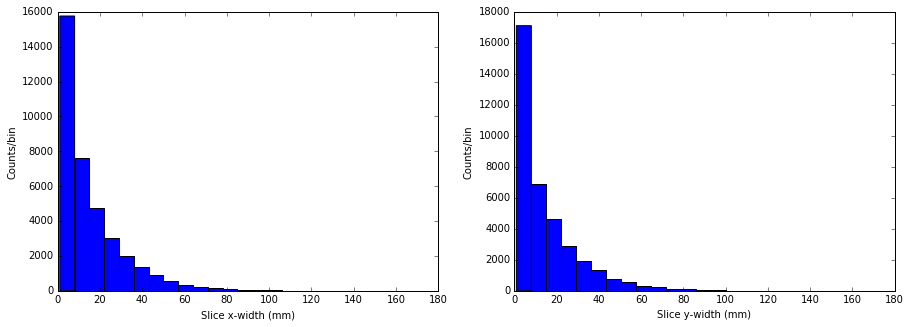

Total of 36947 slices.


In [7]:
# Plot the histograms.
fig = plt.figure()
fig.set_figheight(5.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121)
ax1.hist(xrng,bins=25)
ax1.set_xlabel("Slice x-width (mm)")
ax1.set_ylabel("Counts/bin")

ax2 = fig.add_subplot(122)
ax2.hist(yrng,bins=25)
ax2.set_xlabel("Slice y-width (mm)")
ax2.set_ylabel("Counts/bin")

plt.show()

print "Total of {0} slices.".format(len(xrng))

Slice one event and plot one slice (full range).

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


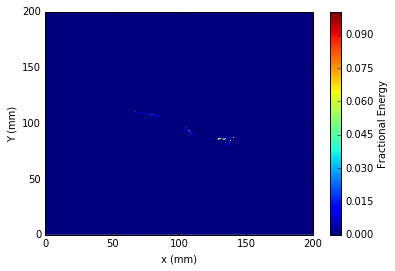

In [8]:
# Choose the event and slice number to plot.
plt_evt = 23
plt_sl = 3

# -----------------------------------------------------------------------------------------------------
en,sl = slice_evt(h5f,plt_evt,slice_width)
max_en = np.where(en == en.max())[0][0]

# Get lists of the nonzero x,y,z indices and E values.
pslice = sl[plt_sl]
nzy,nzx = np.nonzero(pslice)
nze = pslice[np.nonzero(pslice)]

# Create the plot.
fig = plt.figure()
ax1 = fig.add_subplot(111)
hxz, xxz, yxz = np.histogram2d(nzy, nzx, weights=nze, normed=False, bins=(NY, NX), range=[[0,NY],[0,NX]])
extent3 = [yxz[0], yxz[-1], xxz[0], xxz[-1]]
sp3 = ax1.imshow(hxz, extent=extent3, interpolation='none', aspect='auto', origin='lower')
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("Y (mm)")
cbp3 = plt.colorbar(sp3);
cbp3.set_label('Fractional Energy');

plt.show()

Close the HDF5 file containing the Geant4 voxels of the event.

In [9]:
h5f.close()

## DNN training and reconstruction

The stored events and SiPM maps can now be read in and used to train a DNN.

In [13]:
# Number of events to read.
Nevts_train = 20000
Nevts_test = 2000
gridSize = int(RNG_LIM*RNG_LIM)
mapSize = nsipm*nsipm

x_train = np.zeros([Nevts_train,mapSize])
x_test = np.zeros([Nevts_test,mapSize])
y_train = np.zeros([Nevts_train,gridSize])
y_test = np.zeros([Nevts_test,gridSize])

# Open the HDF5 file.
evtFile = h5py.File("slices.h5",'r')

# Start reading the events.
print "{0} events available".format(len(evtFile))
nevents = min(len(evtFile),Nevts_train+Nevts_test)
for ee in range(nevents):
    
    # Get the data from the HDF5 file.
    slice_obj = evtFile["slice{0}".format(ee)]
    map_obj = evtFile["sipm{0}".format(ee)]
    
    # Create the grid.
    xslices = slice_obj[0]; yslices = slice_obj[1]; eslices = slice_obj[2]
    slice_grid = np.zeros(gridSize)
    for xv,yv,ev in zip(xslices,yslices,eslices):
        igrid = xv + RNG_LIM*yv
        slice_grid[igrid] += ev
    
    # Store the event.
    if(ee >= Nevts_train): 
        x_test[ee-Nevts_train] = map_obj
        y_test[ee-Nevts_train] = slice_grid
    else:
        x_train[ee] = map_obj
        y_train[ee] = slice_grid

73646 events available


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Plot one event: grid distribution and corresponding SiPM map

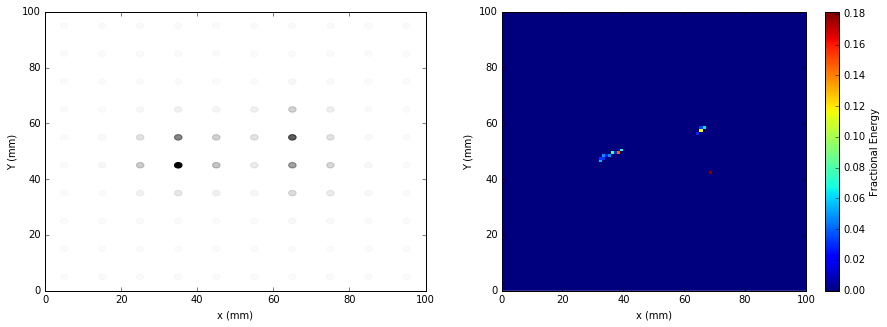

In [14]:
# Plot one event.
plt_train = False   # set to True to plot a training event, False to plot a test event
pevt = 2            # the event number
if(plt_train):
    xarr = x_train[pevt]
    yarr = y_train[pevt]
else:
    xarr = x_test[pevt]
    yarr = y_test[pevt]

# Create the figure.
fig = plt.figure();
fig.set_figheight(5.0)
fig.set_figwidth(15.0)

# Plot the SiPM response map.
ax1 = fig.add_subplot(121); 
ax1.axis([0, xlen, 0, ylen]);
probs = (xarr - min(xarr))
probs /= max(probs)
for x,y,p in zip(pos_x, pos_y, probs):
    
    # Set up the location; note we must invert y due to a pi rotation
    #  about the x-axis.
    r = Ellipse(xy=(x,y), width=2., height=2.);
    r.set_facecolor('0');
    r.set_alpha(0.02 + 0.98*p);
    ax1.add_artist(r);
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("Y (mm)")

# Plot the grid.
grid_vals = np.reshape(yarr,(-1,RNG_LIM))
ax2 = fig.add_subplot(122)
extent3 = [0, RNG_LIM, 0, RNG_LIM]
sp3 = ax2.imshow(grid_vals, extent=extent3, interpolation='none', aspect='auto', origin='lower')
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("Y (mm)")
cbp3 = plt.colorbar(sp3);
cbp3.set_label('Fractional Energy');

In [17]:
# Construct a DNN.
model = Sequential()

# Reshape the input
model.add(Reshape((1, nsipm, nsipm), input_shape=(nsipm*nsipm,)))

# 3x3 conv layer: output has shape (None, 64, 10, 10)
model.add(Convolution2D(256, 5, 5, border_mode='same'))
model.add(Activation("relu"))

# Max pooling: output has shape (None, 64, 5, 5)
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), border_mode='valid', dim_ordering='default'))

# 2x2 conv layer: output has shape (None, 32, 5, 5)
model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(Activation("relu"))

# Densely connected layers
newdim = nsipm/2 # new image dimension after pooling layer
model.add(Flatten())
model.add(Dense(output_dim=RNG_LIM*RNG_LIM, input_dim=128*newdim*newdim))
model.add(Activation("softmax"))

# Setup
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.1, momentum=0.9, nesterov=True))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
reshape_4 (Reshape)              (None, 1, 10, 10)     0           reshape_input_4[0][0]            
____________________________________________________________________________________________________
convolution2d_7 (Convolution2D)  (None, 256, 10, 10)   6656        reshape_4[0][0]                  
____________________________________________________________________________________________________
activation_10 (Activation)       (None, 256, 10, 10)   0           convolution2d_7[0][0]            
____________________________________________________________________________________________________
maxpooling2d_4 (MaxPooling2D)    (None, 256, 5, 5)     0           activation_10[0][0]              
___________________________________________________________________________________________

In [18]:
model.fit(x_train, y_train, nb_epoch=10, batch_size=50)

Epoch 1/10
20000/20000 [==============================] - 211s - loss: 5.7146   
Epoch 2/10
20000/20000 [==============================] - 202s - loss: 4.4990   
Epoch 3/10
20000/20000 [==============================] - 201s - loss: 4.1720   
Epoch 4/10
20000/20000 [==============================] - 198s - loss: 3.9772   
Epoch 5/10
20000/20000 [==============================] - 197s - loss: 3.8434   
Epoch 6/10
20000/20000 [==============================] - 920s - loss: 3.7482   
Epoch 7/10
20000/20000 [==============================] - 198s - loss: 3.6712   
Epoch 8/10
20000/20000 [==============================] - 193s - loss: 3.6125   
Epoch 9/10
20000/20000 [==============================] - 200s - loss: 3.5644   
Epoch 10/10
20000/20000 [==============================] - 198s - loss: 3.5162   


In [19]:
# Evaluate the model and produce a list of predictions for the test data.
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=50);
y_pred = model.predict(x_test, batch_size=32, verbose=0)
print("\nMean loss is {0}".format(loss_and_metrics))

2000/2000 [==============================] - 3s     

Mean loss is 3.82053271532


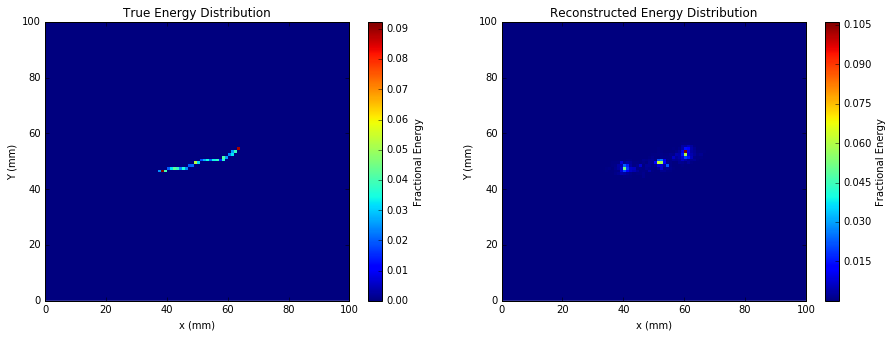

In [21]:
# Plot true vs. reconstructed for a test event.
pevt = 1
y_true = y_test[pevt]
y_calc = y_pred[pevt]

# Create the figure.
fig = plt.figure();
fig.set_figheight(5.0)
fig.set_figwidth(15.0)
extent = [0, RNG_LIM, 0, RNG_LIM]

# Plot the truth.
ax1 = fig.add_subplot(121); 
grid_true = np.reshape(y_true,(-1,RNG_LIM))
sp3 = ax1.imshow(grid_true, extent=extent, interpolation='none', aspect='auto', origin='lower')
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("Y (mm)")
ax1.set_title("True Energy Distribution")
cbp3 = plt.colorbar(sp3);
cbp3.set_label('Fractional Energy');

# Plot the grid.
ax2 = fig.add_subplot(122)
grid_calc = np.reshape(y_calc,(-1,RNG_LIM))
sp3 = ax2.imshow(grid_calc, extent=extent, interpolation='none', aspect='auto', origin='lower')
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("Y (mm)")
ax2.set_title("Reconstructed Energy Distribution")
cbp3 = plt.colorbar(sp3);
cbp3.set_label('Fractional Energy');